In [5]:
import torch
import retinanet.model as model
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet18

In [4]:
retinanet = model.resnet18(20)
retinanet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in /home/datnguyenthanh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-6-7 Python-3.8.16 torch-1.7.1+cu110 CUDA:0 (GeForce RTX 2080 Ti, 11019MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


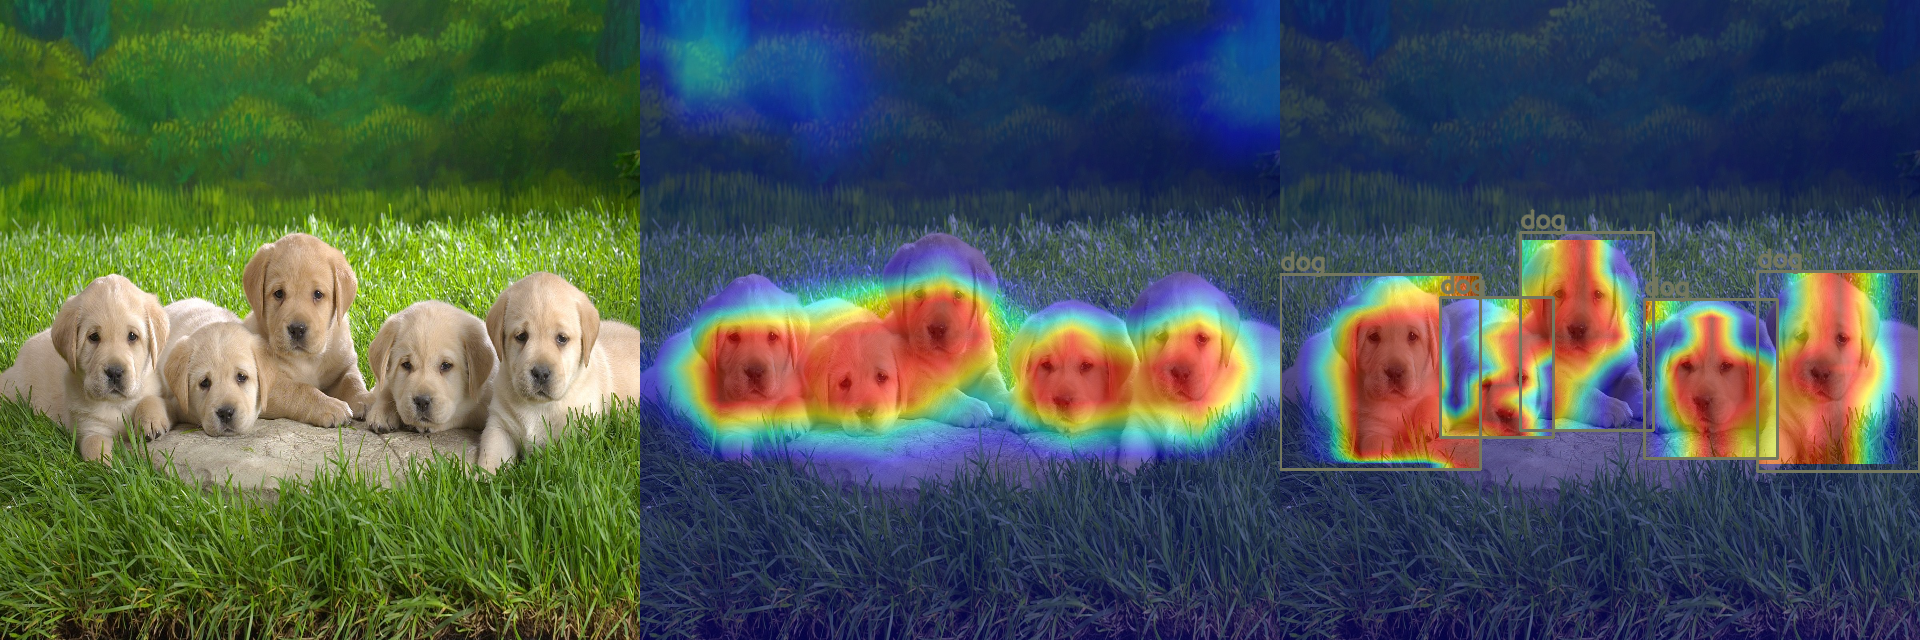

In [21]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
import io
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_(4984818141).jpg"
path = "/home/tungnguyendinh/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_138.jpg"
img = np.array(Image.open("./data/Puppies_(4984818141).jpg"))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
def renormalize_cam_in_bounding_boxes(boxes, colors, names, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    for x1, y1, x2, y2 in boxes:
        renormalized_cam[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_detections(boxes, colors, names, eigencam_image_renormalized)
    return image_with_bounding_boxes

renormalized_cam_image = renormalize_cam_in_bounding_boxes(boxes, colors, names, img, grayscale_cam)
Image.fromarray(np.hstack((rgb_img, cam_image, renormalized_cam_image)))

In [28]:
retinanet.training = False
retinanet.to("cuda")
result = retinanet(tensor.to("cuda"))

[tensor([], device='cuda:0'),
 tensor([], device='cuda:0', dtype=torch.int64),
 tensor([], device='cuda:0')]

In [40]:
def convert_coco_json_to_csv(filename):
    import pandas as pd
    import json
    
    # COCO2017/annotations/instances_val2017.json
    s = json.load(open(filename, 'r'))
    out_file = filename[:-5] + '.csv'
    out = open(out_file, 'w')
    out.write('id,x1,y1,x2,y2,label\n')

    all_ids = []
    for im in s['images']:
        all_ids.append(im['id'])

    all_ids_ann = []
    for ann in s['annotations']:
        image_id = ann['image_id']
        image_id = (12 - len(str(image_id))) * "0" + str(image_id) + ".jpg"
        all_ids_ann.append(image_id)
        x1 = ann['bbox'][0]
        x2 = float(ann['bbox'][0] + ann['bbox'][2])
        y1 = ann['bbox'][1]
        y2 = ann['bbox'][1] + ann['bbox'][3]
        label = ann['category_id']
        out.write('{},{},{},{},{},{}\n'.format(image_id, x1, y1, x2, y2, label))

    all_ids = set(all_ids)
    all_ids_ann = set(all_ids_ann)
    no_annotations = list(all_ids - all_ids_ann)
    # Output images without any annotations
    for image_id in no_annotations:
        out.write('{},{},{},{},{},{}\n'.format(image_id, -1, -1, -1, -1, -1))
    out.close()

    # Sort file by image id
    s1 = pd.read_csv(out_file)
    s1.sort_values('id', inplace=True)
    s1.to_csv(out_file, index=False)

convert_coco_json_to_csv("./data/annotations/instances_val2017.json")

'000000000139.jpg'